# 🧠 Clustering & DBSCAN – A Learning Journey  

This notebook is part of my open learning series on **clustering algorithms** — a space where I document what I learn, test ideas, and share the intuition behind them.  

My goal isn’t just to show results, but to **teach through exploration**:  
each section represents a real milestone in understanding how clustering works — from the classic **K-Means** method to the more flexible **DBSCAN** approach that handles density and noise.  

You’ll find:
- Clear explanations and step-by-step code  
- Visualizations to make every concept intuitive  
- Modular sections that mirror short LinkedIn posts  

By the end, I hope this serves as both a **reference and a teaching resource** for anyone learning clustering.


## 🗺️ Project Roadmap  

This notebook grows as I continue my learning.  
Each section below corresponds to a LinkedIn post where I explain the key idea, code, and visuals in a simple way.

| # | Section | Status | Focus |
|---|----------|--------|--------|
| 1 | Why Clustering? | ✅ | What clustering means and why we use it |
| 2 | K-Means Basics | ⬜ | How K-Means forms clusters through iteration |
| 3 | K-Means Failures | ⬜ | Why K-Means struggles on complex or uneven data |
| 4 | DBSCAN Intuition | ⬜ | Core, border, and noise points explained visually |
| 5 | Cluster Expansion | ⬜ | How DBSCAN grows clusters from core points |
| 6 | Tuning ε & minPts | ⬜ | Finding the right parameters and understanding their effects |
| 7 | DBSCAN vs K-Means | ⬜ | Comparing both approaches and summarizing insights |


In [4]:
# ============================================================
# 📦 Setup
# ============================================================

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Aesthetic settings
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.titlesize"] = 13

# Directory for saving plots
import os
IMGS_DIR = "imgs"
os.makedirs(IMGS_DIR, exist_ok=True)

def savefig(name, dpi=200):
    """Helper to save figures neatly inside the imgs folder."""
    path = os.path.join(IMGS_DIR, name)
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"✅ Figure saved to {path}")


## 1️⃣ Why Clustering?  

Before we even train models or make predictions, we often face a simple question:  
**“What patterns exist in my data?”**  

That’s where *clustering* comes in. It’s a form of **unsupervised learning** —  
where we don’t have labels, but we want to discover structure.  

The goal of clustering is to **group similar data points together** so that  
objects in the same cluster are more alike than those in different clusters.  

You’ll find clustering everywhere:  
- 🧬 grouping genes with similar expression patterns  
- 🛍️ segmenting customers by behavior  
- 📷 organizing image datasets by visual similarity  
- 🩺 identifying patient subtypes in medical data  

To visualize this, let’s start with a simple example:  
how a random set of points can reveal hidden patterns once we apply *any* clustering algorithm.  
Here, we’ll use one of the simplest methods — **K-Means** — just to see how clustering organizes unlabeled data.  
We’ll dive deeper into how K-Means actually works in the *next section*.


✅ Figure saved to imgs\why_clustering.png


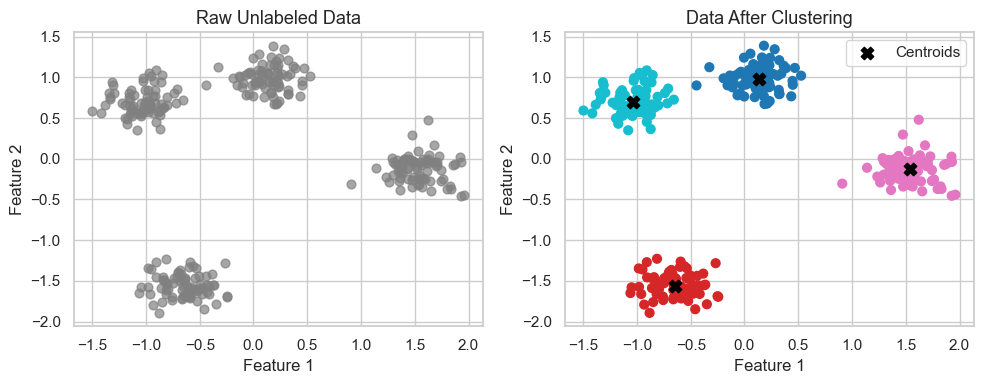

In [5]:
# ============================================================
# 🎨 Visualization: Why Clustering?
# ============================================================

# Create a synthetic dataset (unlabeled data)
X, _ = make_blobs(
    n_samples=300, centers=4, cluster_std=1.0, random_state=42
)

# Standardize features for better scaling
X_scaled = StandardScaler().fit_transform(X)

# Apply K-Means just to show what clustering *does*
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# ---- Plot ----
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left: Unlabeled raw data
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c="gray", alpha=0.7, s=40)
axes[0].set_title("Raw Unlabeled Data")
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Feature 2")

# Right: After clustering
axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap="tab10", s=40)
axes[1].scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    c="black",
    s=80,
    marker="X",
    label="Centroids",
)
axes[1].set_title("Data After Clustering")
axes[1].legend(loc="upper right", frameon=True)
axes[1].set_xlabel("Feature 1")
axes[1].set_ylabel("Feature 2")

plt.tight_layout()
savefig("why_clustering.png")
plt.show()


### 💭 Reflection  

Clustering is one of those concepts that looks simple — until you realize how powerful it actually is.  
From an unlabeled cloud of points, the algorithm can uncover structure, relationships, and meaning.  

In the example above, we didn’t tell the model what to look for.  
It *discovered* the groups based purely on distance and similarity.  

That’s the beauty of unsupervised learning:  
it helps us **see order in chaos** — a first step before any advanced modeling.  

In the next part, we’ll take a closer look at the algorithm we just used — **K-Means** —  
to understand how it identifies those clusters step by step.

